**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob

%matplotlib inline

In [2]:
def readImages(imageNames):
    images = []
    for imgName in imageNames:
        img = cv2.imread(imgName)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        images.append(img)
    return images


car_images = glob.glob('training/vehicles/vehicles/**/*.png')
noncar_images = glob.glob('training/non-vehicles/non-vehicles/**/*.png')     

cars = readImages(car_images)
notcars = readImages(noncar_images)
print(len(car_images), len(noncar_images))

8792 8968


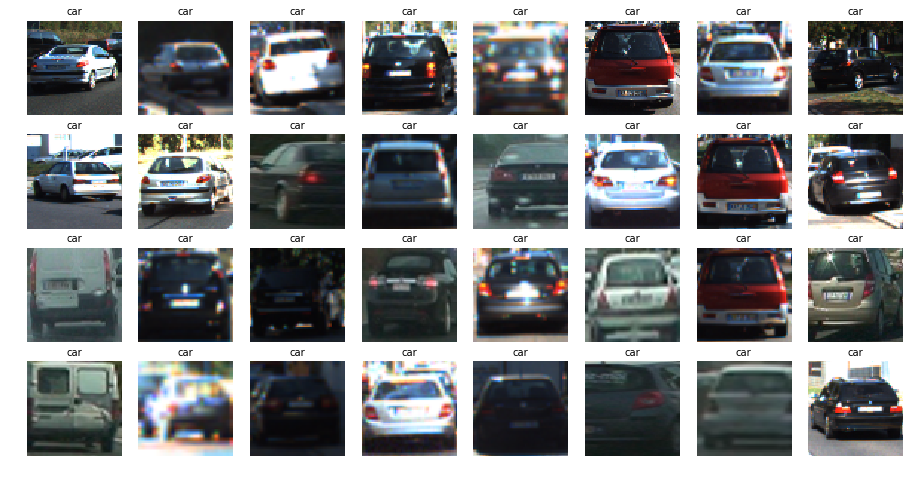

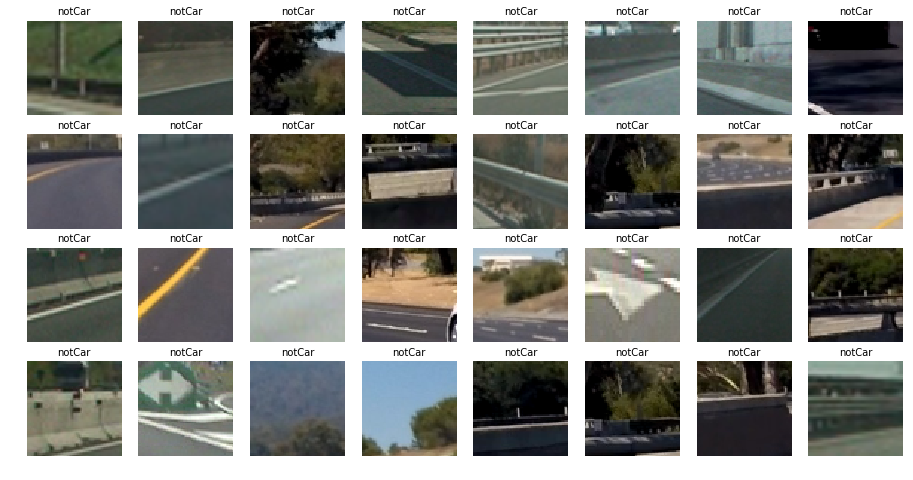

In [3]:

fig,  axs  =  plt.subplots(4,8, figsize=(16,8))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cars[np.random.randint(0,len(car_images))]
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)

fig,  axs  =  plt.subplots(4,8, figsize=(16,8))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
    
for i in np.arange(32):
    img = notcars[np.random.randint(0,len(noncar_images))]
    axs[i].axis('off')
    axs[i].set_title('notCar', fontsize=10)
    axs[i].imshow(img)

### HOG and color historgram

In [4]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler


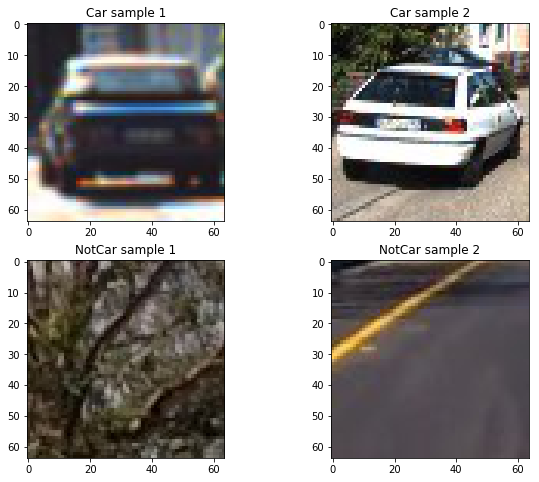

In [5]:
testCarImag1_name = 'training/vehicles_smallset/cars1/' + '1.jpeg'
testCarImag2_name = 'training/vehicles_smallset/cars1/' + '17.jpeg'

img = cv2.imread(testCarImag1_name)
testCarImag1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.imread(testCarImag2_name)
testCarImag2 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

testNotCarImag1_name = 'training/non-vehicles_smallset/notcars1/' + 'extra64.jpeg'
testNotCarImag2_name = 'training/non-vehicles_smallset/notcars1/' + 'extra119.jpeg'

img = cv2.imread(testNotCarImag1_name)
testNotCarImag1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.imread(testNotCarImag2_name)
testNotCarImag2 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)


plt.figure(figsize=(10,8))
plt.subplot(221)
plt.imshow(testCarImag1)
plt.title("Car sample 1")

plt.subplot(222)
plt.imshow(testCarImag2)
plt.title("Car sample 2")
plt.subplot(223)
plt.imshow(testNotCarImag1)
plt.title("NotCar sample 1")
plt.subplot(224)
plt.imshow(testNotCarImag2)
plt.title("NotCar sample 2")

In [6]:
# print(testCarImag1)

### Features

In [7]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm = 'L1',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm = 'L1',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features


/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


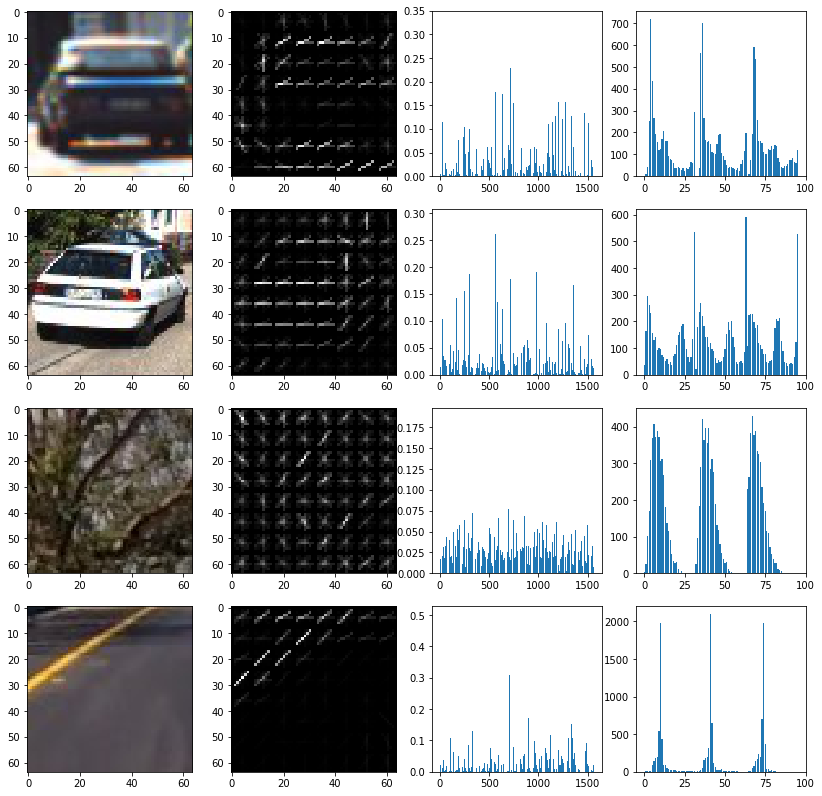

In [8]:
# plt.figure(1, figsize=[14,10])

fig,  axs  =  plt.subplots(4,4, figsize=(14, 14))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()

for i, images in enumerate([testCarImag1, testCarImag2, testNotCarImag1, testNotCarImag2]):
    color_features = color_hist(images)
    
    hog_features, b = get_hog_features(cv2.cvtColor(images,cv2.COLOR_RGB2GRAY), 
                                       orient=8, pix_per_cell=8, cell_per_block=2, vis=True)

    aa = get_hog_features(cv2.cvtColor(images,cv2.COLOR_RGB2GRAY), 
                                       orient=8, pix_per_cell=8, cell_per_block=2, 
                                        vis=False, feature_vec=False)    
    
#     print(aa.shape)
    
    axs[i*4+0].imshow(images, cmap='gray')   

    axs[i*4+1].imshow(b, cmap='gray')
    
    axs[i*4+2].bar(range(7*7*2*2*8), hog_features)
#     print(hog_features.shape)
    
    axs[i*4+3].bar(range(3*32), color_features)
    

In [9]:
def extract_features(images, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='Gray',
                        spatial_feat=True, hist_feat=True, hog_feat=True):  
    features = []
    for img in images:
        single_feature = single_img_features(img, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)
        features.append(single_feature)
    return features
        

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    grayImage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
        elif hog_channel == 'Gray':
            hog_features = get_hog_features(grayImage, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [10]:
class ParameterSet():
    def __init__(self,colorspace, orient, pix_per_cell, cell_per_block 
                , hog_channel, spatial_size, hist_bins, spatial_feat, hist_feat, hog_feat):
        self.colorspace = colorspace # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel # Can be 0, 1, 2, or "ALL"
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.spatial_feat = spatial_feat # Spatial features on or off
        self.hist_feat = hist_feat # Histogram features on or off
        self.hog_feat = hog_feat # HOG features on or off

myParameter1 = ParameterSet('YUV', 11, 16, 2, 'ALL', (32, 32), 32, False, False, True)
myParameter2 = ParameterSet('YUV', 11, 16, 2, 'ALL', (32, 32), 32, False, True, True)
myParameter3 = ParameterSet('YUV', 11, 16, 2, 'ALL', (32, 32), 32, True, True, True)
myParameter4 = ParameterSet('YUV', 11, 16, 2, 'ALL', (16, 16), 32, True, True, True)
myParameter5 = ParameterSet('RGB', 11, 16, 2, 'ALL', (32, 32), 32, False, False,  True)
myParameter6 = ParameterSet('HSV', 11, 16, 2, 'ALL', (32, 32), 32, False, False,  True)
myParameter7 = ParameterSet('HLS', 11, 16, 2, 'ALL', (32, 32), 32, False, False,  True)
myParameter8 = ParameterSet('YUV', 11, 16, 2, 0, (32, 32), 32, False, False,  True)
myParameter9 = ParameterSet('YUV', 8, 8, 2, 'ALL', (32, 32), 32, False, False,  True)
# myParameters1 = ParameterSet('YUV', 11, 16, 2, 'ALL', (32, 32), 32, False, False, True)

In [11]:
np.random.seed(20180610)
rand_state = np.random.randint(0, 100)

In [12]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split


print(len(cars), len(notcars))

# TODO play with these values to see how your classifier
# performs under different binning scenarios


colorspace = myParameter1.colorspace
orient = myParameter1.orient
pix_per_cell = myParameter1.pix_per_cell
cell_per_block = myParameter1.cell_per_block
hog_channel = myParameter1.hog_channel
spatial_size = myParameter1.spatial_size
hist_bins = myParameter1.hist_bins
spatial_feat = myParameter1.spatial_feat
hist_feat = myParameter1.hist_feat
hog_feat = myParameter1.hog_feat


car_features = extract_features(cars, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
# X_scaler = StandardScaler().fit(X_train)
# # Apply the scaler to X_train and X_test
# X_train = X_scaler.transform(X_train)
# X_test = X_scaler.transform(X_test)

print('size of data', len(X_train), len(X_test))

print('Using spatial binning of:',spatial_size,
    'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))


# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
print('------------------------------------------------')


X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
print('------------------------------------------------')


8792 8968


/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


size of data 14208 3552
Using spatial binning of: (32, 32) and 32 histogram bins
Feature vector length: 1188
0.62 Seconds to train SVC...
Test Accuracy of SVC =  0.9865
------------------------------------------------
1.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9851
------------------------------------------------


In [13]:
myParameters = [myParameter1, myParameter2, myParameter3, myParameter4, myParameter5, 
                myParameter6, myParameter7, myParameter8, myParameter9]

for myParemeter in myParameters:

    colorspace = myParemeter.colorspace
    orient = myParemeter.orient
    pix_per_cell = myParemeter.pix_per_cell
    cell_per_block = myParemeter.cell_per_block
    hog_channel = myParemeter.hog_channel
    spatial_size = myParemeter.spatial_size
    hist_bins = myParemeter.hist_bins
    spatial_feat = myParemeter.spatial_feat
    hist_feat = myParemeter.hist_feat
    hog_feat = myParemeter.hog_feat


    car_features = extract_features(cars, color_space=colorspace, spatial_size=spatial_size,
                            hist_bins=hist_bins, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=colorspace, spatial_size=spatial_size,
                            hist_bins=hist_bins, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)
    
    print('size of data', len(X_train), len(X_test))

    print('Using spatial binning of:',spatial_size,
        'and', hist_bins,'histogram bins')
    print('Feature vector length:', len(X_train[0]))

    # Fit a per-column scaler only on the training data
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X_train and X_test

    if int(spatial_feat+hist_feat+hog_feat) > 1:
        X_train = X_scaler.transform(X_train)
        X_test = X_scaler.transform(X_test)

    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    print('------------------------------------------------')

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


size of data 14208 3552
Using spatial binning of: (32, 32) and 32 histogram bins
Feature vector length: 1188
0.6 Seconds to train SVC...
Test Accuracy of SVC =  0.9865
------------------------------------------------
size of data 14208 3552
Using spatial binning of: (32, 32) and 32 histogram bins
Feature vector length: 1284
1.3 Seconds to train SVC...
Test Accuracy of SVC =  0.989
------------------------------------------------
size of data 14208 3552
Using spatial binning of: (32, 32) and 32 histogram bins
Feature vector length: 4356
6.33 Seconds to train SVC...
Test Accuracy of SVC =  0.9918
------------------------------------------------
size of data 14208 3552
Using spatial binning of: (16, 16) and 32 histogram bins
Feature vector length: 2052
2.27 Seconds to train SVC...
Test Accuracy of SVC =  0.9932
------------------------------------------------
size of data 14208 3552
Using spatial binning of: (32, 32) and 32 histogram bins
Feature vector length: 1188
2.05 Seconds to train 

In [14]:
datainput = [[2,1,3], [2,1,3], [2,1,3]]
aa = StandardScaler().fit(datainput)

datainput = aa.transform(datainput)

print(datainput)

[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
